# Imports

In [1]:
import numpy as np
import gymnasium as gym
import tensorflow as tf
import tqdm.notebook as tqdm
import matplotlib.pyplot as plt



from gymnasium.utils.save_video import save_video

2024-05-07 11:48:40.964563: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-07 11:48:41.830777: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/ttekcor/anaconda3/envs/tf/lib/:/home/ttekcor/anaconda3/envs/tf/lib/
2024-05-07 11:48:41.831056: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/ttekcor/anaconda3/envs/tf/lib/:/home/ttekcor/ana

In [2]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print('GPU enable')
    except Exception as e:
        print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU enable


2024-05-07 11:48:45.096401: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:04:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-07 11:48:45.122436: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:04:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-07 11:48:45.122484: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:04:00.0/numa_node
Your kernel may have been built without NUMA support.


# Environment

Create the [environment](https://gymnasium.farama.org/environments/box2d/bipedal_walker/).

In [3]:
env = gym.make('BipedalWalker-v3', hardcore=False)
eval_env = gym.make('BipedalWalker-v3', hardcore=False)

# Replay Buffer

Create a replay buffer to hold game history

In [4]:
class ReplayBuffer:

    def __init__(self, max_size: int, observation_space: gym.spaces.Space, action_space: gym.spaces.Space, seed: int | None = None):
        """Stores the replay history with a maximum of `max_size` entries, removing old entries as needed.

        Parameters:
            max_size: maximal number of entries to keep
            observation_space: specification of the observation space
            action_space: specification of the action space
            seed: seed to initialize the internal random number generator for reproducibility"""
        self.max_size = max_size
        self.done = np.zeros(max_size)
        self.step = 0
        self.rng = np.random.default_rng(seed=seed)
        self.len = 0

        self.current_state = np.zeros((max_size, *observation_space.shape))
        self.action = np.zeros((max_size, *action_space.shape), dtype=int)
        self.reward = np.zeros(max_size)
        self.next_state = np.zeros((max_size, *observation_space.shape))
        
    def add(self, current_observation: np.ndarray, action: np.ndarray, reward: float, next_observation: np.ndarray, done: bool) -> None:
        """Add a new entry to the buffer.

        Parameters:
            current_observation: environment state observed at the current step
            action: action taken by the model
            reward: reward received after taking the action
            next_observation: environment state obversed after taking the action
            done: whether the episode has ended or not"""
        self.current_state[self.step] = current_observation
        self.action[self.step] = action
        self.reward[self.step] = reward
        self.next_state[self.step] = next_observation
        self.done[self.step] = done
        self.step = (self.step + 1) % self.max_size
        self.len = min(self.len + 1, self.max_size)
        
    def sample(self, n_samples: int, replace: bool = True) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        """Randomly samples `n_samples` from the buffer.

        Parameters:
            n_samples: number of samples to select
            replace: sample with or without replacement

        Returns:
            current observations, actions, rewards, next observations, done"""
        indicies = self.rng.choice(self.len, size=n_samples, replace=replace)
        return (
            self.current_state[indicies], 
            self.action[indicies], 
            self.reward[indicies], 
            self.next_state[indicies], 
            self.done[indicies]
        )

    def clear(self) -> None:
        """Clears the buffer"""
        self.step = self.len = 0

    def __getitem__(self, index: int) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        """Gets a sample at `index`

        Parameters:
            index: index of the sample to get

        Returns:
            current observation, action, reward, next observation, done"""
        return (
            self.current_state[index], 
            self.action[index], 
            self.reward[index], 
            self.next_state[index], 
            self.done[index]
        )
        
    def __len__(self) -> int:
        """Returns the number of entries in the buffer"""
        return self.len

# Model

Implement your model

In [5]:
def get_name(prefix: str | None = None, suffix: str | None = None, separator: str = '/') -> str | None:
    return prefix and prefix + separator + suffix or suffix or None

In [6]:
def get_model(
    input_features: tuple | int, 
    features: int,
    out_features: tuple | int,
    blocks: int, 
    activation: str | tf.keras.layers.Activation | None = 'silu',
    dropout: float = 0.,
    multiply_freq: int = 1,
    kind_of_model: str | None = None,
    name: str | None = None
) -> tf.keras.Model:
    if kind_of_model == 'policy':
        inputs = x = tf.keras.layers.Input((input_features, ), name=get_name(name, 'input'))
    else:
        input1 = tf.keras.layers.Input((input_features, ), name=get_name(name, 'observation_input'))
        input2 = tf.keras.layers.Input((4, ), name=get_name(name, 'action_input'))
        x = tf.keras.layers.concatenate([input1, input2])
        inputs = [input1, input2]

    for i in range(blocks):
        x = tf.keras.layers.Dense(features, activation=activation, name=get_name(name, f'dense_{i}'))(x)
        if dropout > 0:
            x = tf.keras.layers.Dropout(dropout, name=get_name(name, f'dropout_{i}'))(x)

        if multiply_freq > 0 and (i + 1) % multiply_freq == 0:
            features *= 2
    if kind_of_model == 'policy':
        x = tf.keras.layers.Dense(out_features, activation='tanh', name=get_name(name, 'prediction'))(x)
    else:
        x = tf.keras.layers.Dense(out_features, name=get_name(name, 'prediction'))(x)
    return tf.keras.Model(inputs=inputs, outputs=x, name=name)

# Play the game

Implement interacting with the environment and storing entries to the replay buffer

In [7]:
def play_game(model: tf.keras.Model, buffer: ReplayBuffer | None, env: gym.Env, max_steps: int, observation: np.ndarray | None = None) -> np.ndarray:
    """Play game and record

    Parameters:
        model: the model to get actions with
        buffer: replay buffer to store the entries to
        env: environment to play
        max_steps: maximal number of steps to perform
        observation: the observation to resume from

    Returns:
        the last observation"""
    if observation is None:
        observation, _ = env.reset()

    buffer = buffer if buffer is not None else ReplayBuffer(1)

    for i in range(max_steps):
        a = model(observation[None], training=False).numpy()[0] # Observe state `s` and select action `a`
        
        new_observation, score, done, terminated, _ = env.step(a) # Execute `a` in the environment
        
        buffer.add(observation, a, score, new_observation, done) # Store `(s, a, r, s', d)` in buffer

        if done or terminated: # If `s'` is terminal, reset environment state
            observation, _ = env.reset()
            continue
            
        observation = new_observation

    return observation

# Loss

In [8]:
def ddpg_loss(
    current_observation: tf.Tensor, 
    action: tf.Tensor, 
    reward: tf.Tensor, 
    next_observation: tf.Tensor,
    done: tf.Tensor,
    q_model: tf.keras.Model,
    policy_model: tf.keras.Model,
    target_q_model: tf.keras.Model,
    target_policy_model: tf.keras.Model,
    gamma: float
) -> tuple[tf.Tensor, tf.Tensor]:
    """Computes Deep Deterministic Policy Gradient.

    Parameters:
        current_observation: observations at the current time step
        action: actions taken at the current time step
        reward: rewards at the current time step
        next_observation: observations at the next time step
        done: whether the episode has ended or not
        q_model: q-function model
        policy_model: action prediction model
        target_q_model: target q-function model
        target_policy_model: target action prediction model
        gamma: discount

    Returns:
        Computed losses for q-function and policy models"""
    q_current = q_model((current_observation, action))
    q_next = target_q_model((next_observation, target_policy_model(next_observation)))

    q_ref = reward + gamma * (1. - done) * q_next
    q_loss = tf.math.reduce_mean(tf.square(q_current - q_ref))

    policy_loss = -tf.math.reduce_mean(q_model((current_observation, policy_model(current_observation))))

    return q_loss, policy_loss

# Training

Create models, replay buffers, optimizer. Implement training loop, show training progress and perform model evaluation once in a while

In [9]:
model = get_model(24, 16, 1, 12, name='walker', dropout=0.1, multiply_freq=2, activation='swish')
model.summary()

2024-05-07 11:49:28.776728: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-07 11:49:28.778580: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:04:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-07 11:49:28.778627: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:04:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-07 11:49:28.778648: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:04:00.0/numa_nod

Model: "walker"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 walker/observation_input (Inpu  [(None, 24)]        0           []                               
 tLayer)                                                                                          
                                                                                                  
 walker/action_input (InputLaye  [(None, 4)]         0           []                               
 r)                                                                                               
                                                                                                  
 concatenate (Concatenate)      (None, 28)           0           ['walker/observation_input[0][0]'
                                                                 , 'walker/action_input[0][0]

In [10]:
target_model = get_model(24, 16, 1, 12, name='target_walker', multiply_freq=2, activation='swish')
target_model.trainable = False
target_model.set_weights(model.get_weights())

In [11]:
policy_model = get_model(24, 16, 4, 10, name='policy_model', multiply_freq=2, kind_of_model='policy') # Предсказывает действие по состоянию среды
policy_model.summary()

Model: "policy_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 policy_model/input (InputLa  [(None, 24)]             0         
 yer)                                                            
                                                                 
 policy_model/dense_0 (Dense  (None, 16)               400       
 )                                                               
                                                                 
 policy_model/dense_1 (Dense  (None, 16)               272       
 )                                                               
                                                                 
 policy_model/dense_2 (Dense  (None, 32)               544       
 )                                                               
                                                                 
 policy_model/dense_3 (Dense  (None, 32)              

In [12]:
target_policy_model = get_model(24, 16, 4, 10, name='target_policy_model', multiply_freq=2, kind_of_model='policy')
target_policy_model.trainable = False
target_policy_model.set_weights(policy_model.get_weights())

In [13]:
train_buffer = ReplayBuffer(10000, observation_space=env.observation_space, action_space=env.action_space)

In [14]:
eval_buffer = ReplayBuffer(1000, observation_space=eval_env.observation_space, action_space=eval_env.action_space)

In [15]:
optimizer = tf.keras.optimizers.legacy.Adam(1e-4, clipnorm=5, decay=2e-5)

In [21]:
epochs = 10000
save_loss_frequency = 100
batch_size = 1024
update_frequency = 128
eval_frequency = 512
steps_per_epoch = 32
eval_steps = 1000
initial_samples = 1000
n_evals = 5
eval_threshold = 400
polyak = 0.707

In [23]:
def mulpiply_weights(model: tf.keras.Model, target_model: tf.keras.Model, number: float | int) -> list[np.ndarray]:
    return [number * target_weights + (1. - number) * model_weights for target_weights, model_weights in zip(target_model.get_weights(), model.get_weights())]

In [18]:
print(tf.__version__)

2.11.1


In [19]:
def apply_gradients(self, grads_and_vars, name=None):
    return super().apply_gradients(grads_and_vars)

In [24]:
q_losses = []
p_losses = []
total_q_loss = 0
total_p_loss = 0
eval_score = 0
all_q_loss_saver = []
all_p_loss_saver = []

s, _ = env.reset()
pbar = tqdm.trange(epochs)
for i in pbar:
    
    s = play_game(policy_model, train_buffer, env, steps_per_epoch, observation=s) # Select action, play and store in buffer
    
    vals = train_buffer.sample(batch_size) # Randomly sample a batch of transitions


    with tf.GradientTape(watch_accessed_variables=False) as q_g, tf.GradientTape(watch_accessed_variables=False) as p_g:
        q_g.watch(model.trainable_weights)
        p_g.watch(policy_model.trainable_weights)
        q_loss, policy_loss = ddpg_loss(*vals, model, policy_model, target_model, target_policy_model, 0.99) # MSBE and mean score from Policy

    q_gradient = q_g.gradient(q_loss, model.trainable_weights)
    optimizer.apply_gradients(zip(q_gradient, model.trainable_weights))

    p_gradient = p_g.gradient(policy_loss, policy_model.trainable_weights)
    optimizer.apply_gradients(zip(p_gradient, policy_model.trainable_weights))
    
        
    q_losses.append(q_loss.numpy())
    p_losses.append(policy_loss.numpy())
    
    total_q_loss += q_losses[-1]
    total_p_loss += p_losses[-1]

    if (i + 1) % update_frequency == 0:
        target_model.set_weights(mulpiply_weights(model, target_model, polyak))
        target_policy_model.set_weights(mulpiply_weights(policy_model, target_policy_model, polyak))

    if (i + 1) % eval_frequency == 0:
        eval_score = 0

        for i in range(n_evals):
            eval_buffer.clear()
            play_game(policy_model, eval_buffer, eval_env, eval_steps)
            eval_score += eval_buffer.reward[:len(eval_buffer)].sum()

        eval_score /= n_evals
        if eval_score >= eval_threshold:
            break
    if (i + 1) % save_loss_frequency == 0:
        all_q_loss_saver.append(total_q_loss / (i + 1))
        all_p_loss_saver.append(total_p_loss / (i + 1))

    pbar.set_description(f'Qloss: {q_losses[-1]:.5f}; AllQloss: {total_q_loss / (i + 1):.5f}; Ploss: {p_losses[-1]:.5f}; AllPloss: {total_p_loss / (i + 1):.5f}; E: {eval_score:.5f}')

  0%|          | 0/10000 [00:00<?, ?it/s]

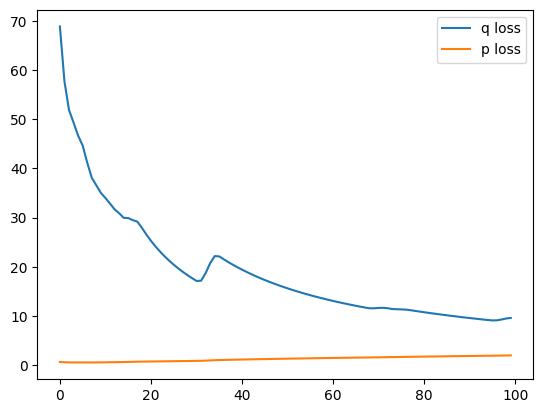

In [25]:
plt.plot(list(range(len(all_q_loss_saver))), all_q_loss_saver, label='q loss')
plt.plot(list(range(len(all_p_loss_saver))), all_p_loss_saver, label='p loss')
plt.legend()
plt.show()

In [26]:
model.save_weights(f'./models/walker_model_{eval_score}')

In [27]:
eval_score

-1261.17298518071

# Testing

Test the model on the environment and get a cool video

In [56]:
def save_gameplay(model: tf.keras.Model, render_mode: str = 'rgb_array_list', n_frames: int = 1000, buffer_capacity: int = 1000):
    env = gym.make('BipedalWalker-v3', hardcore=False, render_mode=render_mode)
    buffer = ReplayBuffer(1000, env.observation_space, env.action_space)
    
    play_game(model, buffer, env, n_frames)
    #if you wanna use this line change 'render_mode' -> 'rgb_array_list'
    render = env.render()
    return render,buffer

In [46]:
model.load_weights("models/walker_model_-1261.17298518071")

In [57]:
l,k = save_gameplay(policy_model)


In [58]:
gym.utils.save_video.save_video(l, 'videos', durations=[1] * 1000, fps=24)

Moviepy - Building video /home/ttekcor/videos/rl-video-episode-0.mp4.
Moviepy - Writing video /home/ttekcor/videos/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /home/ttekcor/videos/rl-video-episode-0.mp4


In [49]:
!pip install moviepy --upgrade
!pip install ffmpeg --upgrade


/bin/bash: /home/ttekcor/anaconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/ttekcor/anaconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [59]:
k.reward.sum()

-54.50095793136015